In [1]:
print('Loading modules....')

import os, sys


import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl
import pickle as pkl
import ROOT as rt
import seaborn as sns
import operator as op
import pandas as pd
from collections import Counter
from tqdm import tqdm
print('modules loaded...')

Loading modules....


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject
/usr/local/lib/python3.8/dist-packages/CDMSDataCatalog/CDMSDataCatalog.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in 

Welcome to JupyROOT 6.24/06
modules loaded...


In [2]:
dataset = 'v2.1.1'
detNum = 1

In [3]:
prod='CUTE_T3_GeActivation_%s_V05-00_P0.2.'%(dataset)
base = '/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/%s/Submerged'%(prod)

if(dataset == 'prompt'):
    base = '/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged'
    prod = 'Prompt_V04-15_P0.2.1'


file_prefix = prod

#Only 4 series
series = ['23231219_034952','23231219_110331','23231218_223530','23231217_212512']

# 11 data series
# series = [
#     '23231220_012745','23231219_184002','23231219_110331','23231219_034952','23231218_223530',
#     '23231218_190035','23231218_152721','23231218_093255','23231217_212512','23231217_171613',
#     '23231217_135018'
#          ]

# 20 data series
# series = [
#     '23231216_013604', '23231216_043946', '23231216_100125', '23231216_115012', '23231216_145300',
#     '23231216_182937', '23231216_194929', '23231216_211119', '23231216_233807', '23231217_135018',
#     '23231217_171613', '23231217_212512', '23231218_093255', '23231218_152721', '23231218_190035',
#     '23231218_223530', '23231219_034952', '23231219_110331', '23231219_184002', '23231220_012745'
# ]

filePath = []
found_series = []
for ser in series:
    
    fp = '%s/%s_%s.root'%(base,file_prefix,ser)
    if(os.path.exists(fp)):
        print(ser,' : ',fp)
        filePath.append(fp)
        found_series.append(ser)
    else:
        print('not found: ',fp)
series = found_series
print('Found series = ',series)
print('Number of found series = ',len(series))


23231219_034952  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231219_034952.root
23231219_110331  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231219_110331.root
23231218_223530  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231218_223530.root
23231217_212512  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231217_212512.root
Found series =  ['23231219_034952', '23231219_110331', '23231218_223530', '23231217_212512']
Number of found series =  4


In [4]:
print('Loading RQ and Event Tree...')
RQ=[]
for i,ser in enumerate(series):
    RQ.append(uproot.open(filePath[i])['rqDir/zip%d'%(detNum)]) 

eventTree=[]
for i,ser in enumerate(series):
    eventTree.append(uproot.open(filePath[i])['rqDir/eventTree']) 

print('done..')


print('Loading OF spefic data....')
#Load RQs from processed files
channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
OFbs={}

for i,key in enumerate(series):
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for c in channels:
        if(detNum == '3' and c == 'PAS1'):
            print('\tSkipping Z3-PAS1...')
            continue
        tc[c]=(RQ[i][c+"OFchisq"].array(library='np'))
        ta[c]=(RQ[i][c+"OFamps"].array(library='np'))
        ta0[c]=(RQ[i][c+"OFamps0"].array(library='np'))
        td[c]=(RQ[i][c+"OFdelay"].array(library='np'))
        
        if(c!='PT'):
            tn[c] = (RQ[i][c+"norm"].array(library='np'))
            tbs[c] = (RQ[i][c+"bs"].array(library='np'))

            
    OFchiq[key]=tc
    OFamps[key]=ta
    OFamps0[key]=ta0
    OFdelay[key]=td
    OFnorms[key]=tn
    OFbs[key]=tbs
    print('%s loaded'%(key))
    
print('done!')

print(' Loading Event specific data....')


TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]

R2 = {} # Radial parameter for S2
R1 = {} # Radial parameter for S1
amp_diff = {}  
amp_diff_abs = {}
for i,key in enumerate(series):
    TriggerTime.append(eventTree[i]["TriggerTime"].array())
    TriggerType.append(eventTree[i]["TriggerType"].array())
    EventNumber.append(eventTree[i]["EventNumber"].array())
    TrigDet.append(eventTree[i]["TriggerDetectorNum"].array())
    TriggerMask.append(eventTree[i]["TriggerMask"].array())
    EventTime.append(eventTree[i]["EventTime"].array())
    
    R2[key] = OFdelay[key]['PFS2'] - OFdelay[key]['PAS2']
    R1[key] = OFdelay[key]['PFS1'] - OFdelay[key]['PAS1']
    amp_diff[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])/(OFamps[key]['PFS2'] + OFamps[key]['PAS2'])
    amp_diff_abs[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])
    print('%s loaded'%(key))

print('Done!')

Loading RQ and Event Tree...
done..
Loading OF spefic data....
23231219_034952 loaded
23231219_110331 loaded
23231218_223530 loaded
23231217_212512 loaded
done!
 Loading Event specific data....
23231219_034952 loaded
23231219_110331 loaded
23231218_223530 loaded
23231217_212512 loaded
Done!


In [5]:
chan = 'PT'
amps = {}

for c in channels:
    if(c == 'PT'):
        continue
    temp = []
    for idx, key in enumerate(series):
        mask = (TriggerType[idx] == 1) & (TrigDet[idx] == detNum) & (OFamps[key][chan] > 3e-6) & (OFamps[key][chan] < 4.2e-6) & (OFchiq[key][chan] < 5e5) & (abs(OFdelay[key][chan])*1e3 < 20)
        temp = np.append(temp, OFamps[key][c][mask])
        #print(series,' : ',EventNumber[idx][mask])
    amps[c] = temp
    print('%s loaded..: %d'%(c, len(amps[c])))



PAS1 loaded..: 143
PBS1 loaded..: 143
PCS1 loaded..: 143
PDS1 loaded..: 143
PES1 loaded..: 143
PFS1 loaded..: 143
PAS2 loaded..: 143
PBS2 loaded..: 143
PCS2 loaded..: 143
PDS2 loaded..: 143
PES2 loaded..: 143
PFS2 loaded..: 143


In [6]:
chan = 'PT'
hists1 = []
hists2 = []
low = 0.6
high = 1.6
step = 0.2

for j1, i1 in (enumerate(np.arange(low,high,step))):
    a = i1
    for j2, i2 in enumerate(np.arange(low,high,step)):
        b = i2
        for j3, i3 in enumerate(np.arange(low,high,step)):
            c = i3
            for j4, i4 in enumerate(np.arange(low,high,step)):
                d = i4
                for j5, i5 in enumerate(np.arange(low,high,step)):
                    e = i5
                    for j6, i6 in enumerate(np.arange(low,high,step)):
                        f = i6
                        hname = 'h_S1_a%02d_b%02d_c%02d_d%02d_e%02d_f%02d'%(j1, j2, j3, j4, j5, j6)
                        temp1 = rt.TH1F(hname, hname, 200, 1.0, 4.5)
                        hname = 'h_S2_a%02d_b%02d_c%02d_d%02d_e%02d_f%02d'%(j1, j2, j3, j4, j5, j6)
                        temp2 = rt.TH1F(hname, hname, 200, 1.0, 4.5)
                        for i in range(len(amps['PAS1'])):
                            s = a*amps['PAS1'][i] + b*amps['PBS1'][i] + c*amps['PCS1'][i] + d*amps['PDS1'][i] + e*amps['PES1'][i] + f*amps['PFS1'][i]
                            temp1.Fill(s*1e6)
                            s = a*amps['PAS2'][i] + b*amps['PBS2'][i] + c*amps['PCS2'][i] + d*amps['PDS2'][i] + e*amps['PES2'][i] + f*amps['PFS2'][i]
                            temp2.Fill(s*1e6)
                        hists1.append(temp1)
                        hists2.append(temp2)
    print('%d : %0.1f done'%(j1, i1))
print('all Done')

0 : 0.6 done
1 : 0.8 done
2 : 1.0 done
3 : 1.2 done
4 : 1.4 done
all Done


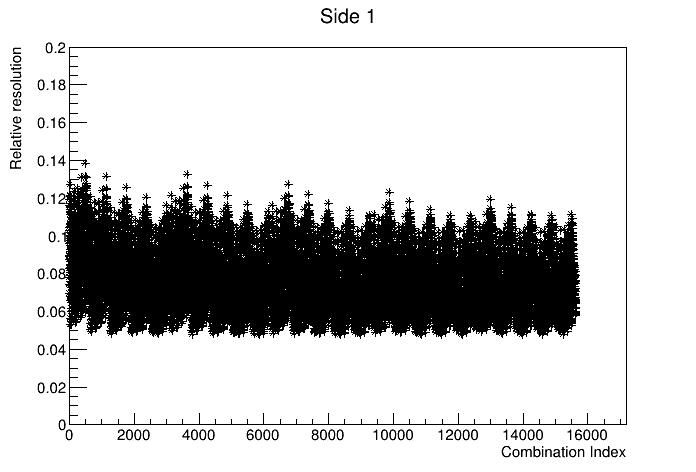

In [7]:
res1 = []
can = rt.TCanvas()
gr = rt.TGraph()
gr.GetXaxis().SetTitle('Combination Index')
gr.GetYaxis().SetTitle('Relative resolution')
for i, h in enumerate(hists1):
    if(h.GetMean() == 0 or h.GetRMS() == 0 or h.GetBinContent(0) > 0.):
        reso_ = 999
    else:
        reso_ = h.GetRMS()/h.GetMean()
        
    res1.append(reso_)
    gr.AddPoint(i, reso_)


gr.Draw('AP*')
gr.SetTitle('Side 1')
gr.GetYaxis().SetRangeUser(0., 0.2)
#gr.GetXaxis().SetRangeUser(7700, 7720)
#7711

can.Draw()


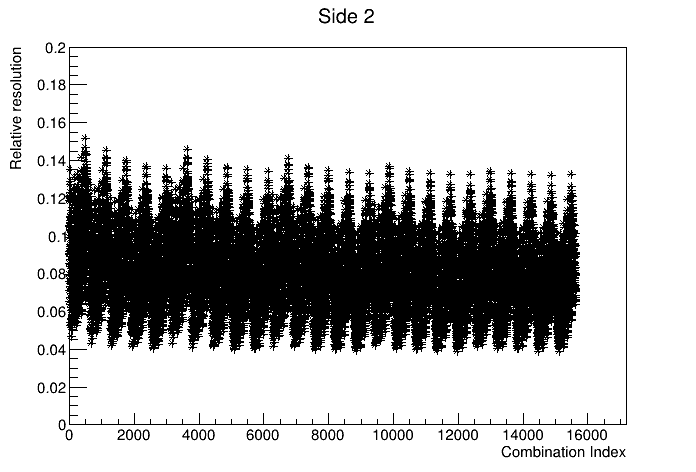

In [8]:
res2 = []
can = rt.TCanvas()
gr = rt.TGraph()
gr.GetXaxis().SetTitle('Combination Index')
gr.GetYaxis().SetTitle('Relative resolution')
for i, h in enumerate(hists2):
    if(h.GetMean() == 0 or h.GetRMS() == 0 or h.GetBinContent(0) > 0.):
        reso_ = 999
    else:
        reso_ = h.GetRMS()/h.GetMean()
        
    res2.append(reso_)
    gr.AddPoint(i, reso_)


gr.Draw('Ap*')
gr.SetTitle('Side 2')
gr.GetYaxis().SetRangeUser(0., 0.2)


can.Draw()

In [9]:
best = np.argmin(res1)
print('Best for side 1 = ',hists1[best].GetName())
print('index S1 = ',best)
best = np.argmin(res2)
print('Best for side 2 = ',hists2[best].GetName())
print('index S2 = ',best)

Best for side 1 =  h_S1_a02_b03_c01_d04_e02_f01
index S1 =  8361
Best for side 2 =  h_S2_a03_b04_c00_d04_e02_f02
index S2 =  11987


0.04759100704605132
overflow:  0.0
underflow:  0.0


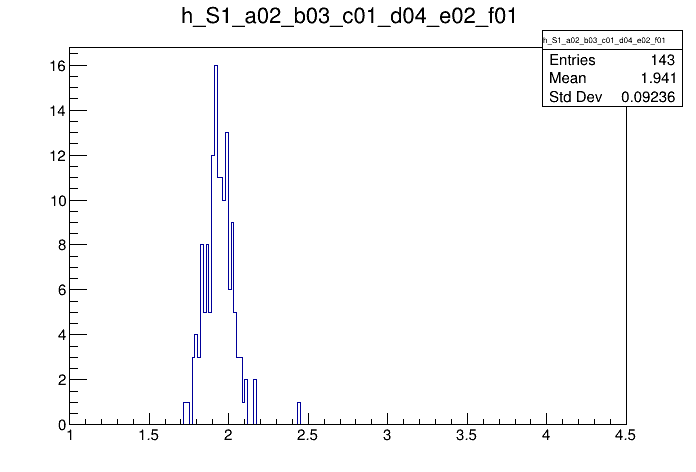

In [10]:
n = 8361
can = rt.TCanvas()
h = hists1[n]
h.Draw()
print(h.GetRMS()/h.GetMean())
nbins = h.GetNbinsX()
print('overflow: ',h.GetBinContent(nbins+1))
print('underflow: ',h.GetBinContent(0))
can.Draw()

0.03856528468297429
overflow:  0.0
underflow:  0.0


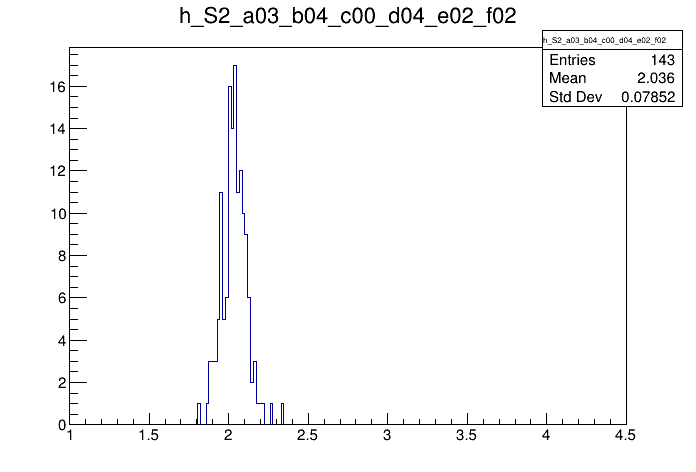

In [11]:
n = 11987
can = rt.TCanvas()
h = hists2[n]
h.Draw()
print(h.GetRMS()/h.GetMean())
nbins = h.GetNbinsX()
print('overflow: ',h.GetBinContent(nbins+1))
print('underflow: ',h.GetBinContent(0))
can.Draw()

In [13]:
low = 0.6
high = 1.6
step = 0.2

for j1, i1 in enumerate(np.arange(low,high,step)):
    print('%d : %0.1f'%(j1, i1))


0 : 0.6
1 : 0.8
2 : 1.0
3 : 1.2
4 : 1.4


In [14]:
calib = {}
calib['PAS1'] = 1.0
calib['PBS1'] = 1.2
calib['PCS1'] = 0.8
calib['PDS1'] = 1.4
calib['PES1'] = 1.0
calib['PFS1'] = 0.8

calib['PAS2'] = 1.2
calib['PBS2'] = 1.4
calib['PCS2'] = 0.6
calib['PDS2'] = 1.4
calib['PES2'] = 1.0
calib['PFS2'] = 1.0
reweight = 0.6

In [15]:
low = 0.1
high = 1.5
step = 0.1
hists_all = []
for j1, i1 in enumerate(np.arange(low,high,step)):
    hname = 'h_both_%0d'%(j1)
    temp1 = rt.TH1F(hname, hname, 200, 1.0, 6.0)
    for i in range(len(amps['PAS1'])):
        s1 = calib['PAS1']*amps['PAS1'][i] + calib['PBS1']*amps['PBS1'][i] + calib['PCS1']*amps['PCS1'][i] + calib['PDS1']*amps['PDS1'][i] + calib['PES1']*amps['PES1'][i] + calib['PFS1']*amps['PFS1'][i]
        s2 = calib['PAS2']*amps['PAS2'][i] + calib['PBS2']*amps['PBS2'][i] + calib['PCS2']*amps['PCS2'][i] + calib['PDS2']*amps['PDS2'][i] + calib['PES2']*amps['PES2'][i] + calib['PFS2']*amps['PFS2'][i]
        s1 = s1*i1
        temp1.Fill((s1+s2)*1e6)
    hists_all.append(temp1)


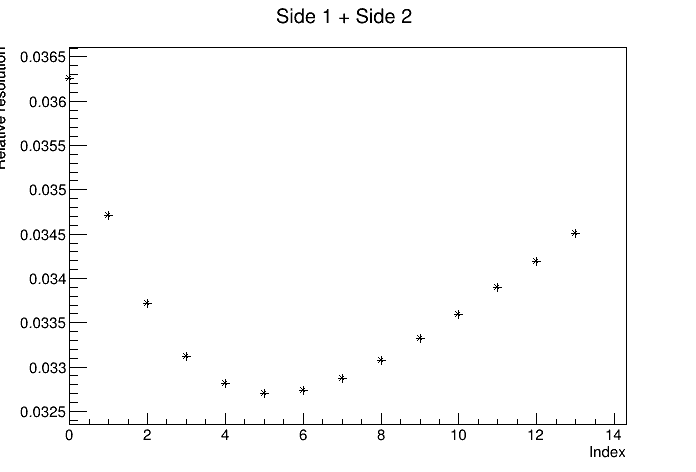

In [16]:
res_all = []
can = rt.TCanvas()
gr = rt.TGraph()
gr.GetXaxis().SetTitle('Index')
gr.GetYaxis().SetTitle('Relative resolution')
for i, h in enumerate(hists_all):
    if(h.GetMean() == 0 or h.GetRMS() == 0 or h.GetBinContent(0) > 5.):
        reso_ = 999
    else:
        reso_ = h.GetRMS()/h.GetMean()
        
    res_all.append(reso_)
    gr.AddPoint(i, reso_)


gr.Draw('AP*')
gr.SetTitle('Side 1 + Side 2')
#gr.GetYaxis().SetRangeUser(0.033, 0.037)
#gr.GetXaxis().SetRangeUser(0, 4)
can.Draw()

In [17]:
best = np.argmin(res_all)
print('Best for side 1 = ',hists_all[best].GetName())
print('index S1 = ',best)

Best for side 1 =  h_both_5
index S1 =  5


In [18]:
low = 0.1
high = 1.5
step = 0.1

for j1, i1 in enumerate(np.arange(low,high,step)):
    print('%d : %0.1f'%(j1, i1))

0 : 0.1
1 : 0.2
2 : 0.3
3 : 0.4
4 : 0.5
5 : 0.6
6 : 0.7
7 : 0.8
8 : 0.9
9 : 1.0
10 : 1.1
11 : 1.2
12 : 1.3
13 : 1.4


0.03270304733313565
overflow:  0.0
underflow:  0.0


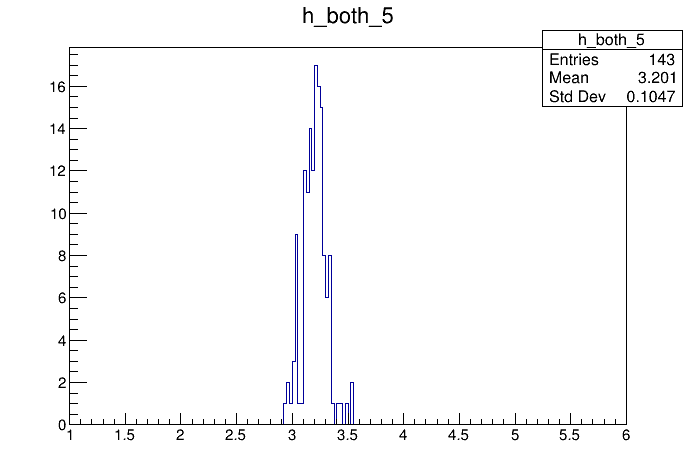

In [19]:
n = 5
can = rt.TCanvas()
h = hists_all[n]
h.Draw()
print(h.GetRMS()/h.GetMean())
nbins = h.GetNbinsX()
print('overflow: ',h.GetBinContent(nbins+1))
print('underflow: ',h.GetBinContent(0))
can.Draw()

In [39]:
filename = 'check_calib_S2.root'
outfile = rt.TFile.Open(filename,'recreate')
outfile.cd()
for h in hists:
    h.Write()
    
outfile.Write()
outfile.Close()

In [23]:
### original ###

calib_official = {
    'PAS1' : 1.1849,
    'PBS1' : 0.9570,
    'PCS1' : 0.9115,
    'PDS1' : 1.0482,
    'PES1' : 0.8659,
    'PFS1' : 0.7292,
    'PAS2' : 1.2351,
    'PBS2' : 1.0477,
    'PCS2' : 0.8518,
    'PDS2' : 1.2948,
    'PES2' : 1.0222,
    'PFS2' : 0.8518
}



calib = {
    
}
reweight = 1.06


calib['PAS1'] = 0.8
calib['PBS1'] = 0.8
calib['PCS1'] = 0.6
calib['PDS1'] = 1.0
calib['PES1'] = 0.8
calib['PFS1'] = 0.6

calib['PAS2'] = 0.8
calib['PBS2'] = 0.8
calib['PCS2'] = 0.4
calib['PDS2'] = 0.8
calib['PES2'] = 0.6
calib['PFS2'] = 0.6
reweight = 0.5

channels=['PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

calib_final = {}
sum_ = 0.0
for c in channels:
    factor = 1.0
    if('S1' in c):
        factor = reweight
    calib_final[c] =  1.0 * calib[c] * factor
    sum_ += calib_final[c]
check = 0.0

print('sum before normalization = ',sum_)
print('normalization factor = ',(12.0/sum_))

for c in channels:
    norm = 12.0/sum_
    check += norm*calib_final[c]
    print("calib['%s'] = %0.4f"%(c,calib_final[c]*norm))
    name=c[1].lower() + c[3]
    #print('%s = %0.4f'%(name,calib_final[c]*norm))
print('after remorm = ',check)

sum before normalization =  6.299999999999999
normalization factor =  1.904761904761905
calib['PAS1'] = 0.7619
calib['PBS1'] = 0.7619
calib['PCS1'] = 0.5714
calib['PDS1'] = 0.9524
calib['PES1'] = 0.7619
calib['PFS1'] = 0.5714
calib['PAS2'] = 1.5238
calib['PBS2'] = 1.5238
calib['PCS2'] = 0.7619
calib['PDS2'] = 1.5238
calib['PES2'] = 1.1429
calib['PFS2'] = 1.1429
after remorm =  12.0
